In [1]:
## processing
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.stats as stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [13]:
def find_circle(x, xc, yc, r):
    y_upper = yc + np.sqrt(r**2 - (x - xc)**2)
    y_lower = yc - np.sqrt(r**2 - (x - xc)**2)
    return y_upper, y_lower


def in_circle(row, xc_2, yc_2, R_2):
    x_coord = row['posX']
    print(x_coord, xc_2, yc_2, R_2)
    if x_coord < (xc_2 - R_2) or x_coord > (xc_2 + R_2):
        return 0
    else:
        upper_bound, lower_bound = find_circle(x_coord, xc_2, yc_2, R_2)
        y_coord = row['posY']
        if y_coord > upper_bound or y_coord < lower_bound:
            return 0
        else:
            return 1

In [3]:
def in_aster_fraction(row):
    series_index = int(row['series'])
    run_index = int(row['run'])
    if run_index < 10:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run000{}/fiber_position.txt'.format(series_index, run_index)
    elif run_index < 100:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run00{}/fiber_position.txt'.format(series_index, run_index)
    else:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run0{}/fiber_position.txt'.format(series_index, run_index)

    df = pd.read_table(fpath,
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
    
    df_short = df[df.length == 1]
    df_long = df[df.length > 1]
    x_long, y_long = df_long['posX'].tolist(), df_long['posY'].tolist()

    def calc_R(xc, yc):
        return np.sqrt((x_long-xc)**2 + (y_long-yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    center_2, ier = optimize.leastsq(f_2, (0, 0))
    xc_2, yc_2 = center_2
    R_2 = calc_R(*center_2).mean()

    col = df_short.apply(in_circle, args=(xc_2, yc_2, R_2), axis=1)
    df_short = df_short.assign(in_circle=col.values)

    #expected_fraction = math.pi * R_2**2 / (math.pi * 16.92**2)

    return sum(df_short['in_circle']) / len(df_short)

## Initial try at building phase diagram

In [2]:
df = pd.read_csv('../data/percolation-phases.csv')

In [3]:
df.head()

,series,run,length,percent_long,globally_contract
0,4,0,2,10,0
1,4,1,3,10,0
2,4,2,4,10,0
3,4,3,5,10,0
4,4,4,6,10,0


In [4]:
df_global = df[df.globally_contract == 1]
df_local = df[df.globally_contract == 0]

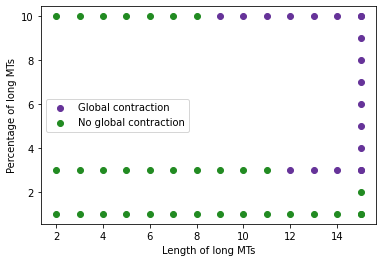

In [5]:
fig, ax = plt.subplots()
ax.scatter(df_global['length'], df_global['percent_long'], color='rebeccapurple')
ax.scatter(df_local['length'], df_local['percent_long'], color='forestgreen')
ax.set_xlabel('Length of long MTs')
ax.set_ylabel('Percentage of long MTs')
ax.legend(['Global contraction', 'No global contraction'])
plt.show()

In [7]:
col = df.apply(in_aster_fraction, axis=1)
df = df.assign(in_aster_frac=col.values)

In [9]:
df = df.groupby(['length', 'percent_long']).mean().reset_index()

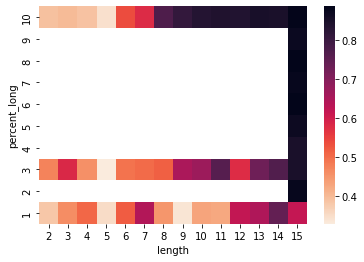

In [12]:
df_pivoted = df.pivot("percent_long", "length", "in_aster_frac")

fig, axes = plt.subplots()
ax = sns.heatmap(df_pivoted, cmap=sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

## Building the full phase diagram

In [4]:
df_list = []
for file_number in range(140):
    filename = '/Users/rosalindpan/thomsonlab/simulation/percolation/full-param-search2/config{}.cym'.format(
                    (4-len(str(file_number)))*'0'+str(file_number))
    file = open(filename, 'r')
    lines = file.readlines()
    num_long = int(lines[34].split()[1])
    length = int(lines[36].strip().split()[2])
    percent_long = int(num_long * length / 1000 * 100)
    if (percent_long) % 2 != 0:
        percent_long += 1
    rv = {'series': 2, 'run': file_number, 'length': length, 'percent_long': percent_long, 'globally_contract':0}
    df_list.append(rv)

In [5]:
df = pd.DataFrame(df_list)

In [6]:
df_list = []
for file_number in range(70):
    filename = '/Users/rosalindpan/thomsonlab/simulation/percolation/full-param-search3/config{}.cym'.format(
                    (4-len(str(file_number)))*'0'+str(file_number))
    file = open(filename, 'r')
    lines = file.readlines()
    num_long = int(lines[34].split()[1])
    length = int(lines[36].strip().split()[2])
    percent_long = int(num_long * length / 1000 * 100)
    if (percent_long) % 2 != 0:
        percent_long += 1
    rv = {'series':3, 'run': file_number, 'length': length, 'percent_long': percent_long, 'globally_contract':0}
    df_list.append(rv)

In [7]:
df2 = pd.DataFrame(df_list)

In [8]:
df_total = pd.concat([df, df2], ignore_index=True)

In [10]:
df_total.head()

,series,run,length,percent_long,globally_contract
0,2,0,2,20,0
1,2,1,3,20,0
2,2,2,4,20,0
3,2,3,5,20,0
4,2,4,6,20,0


In [10]:
df_total.to_csv('../data/percolation-full.csv', index=False)

In [11]:
df_total.head()

,series,run,length,percent_long,globally_contract
0,2,0,2,20,0
1,2,1,3,20,0
2,2,2,4,20,0
3,2,3,5,20,0
4,2,4,6,20,0


In [12]:
col = df_total.apply(in_aster_fraction, axis=1)

In [13]:
df_total = df_total.assign(in_aster_frac=col.values)

In [14]:
df_total = df_total.groupby(['length', 'percent_long']).mean().reset_index()

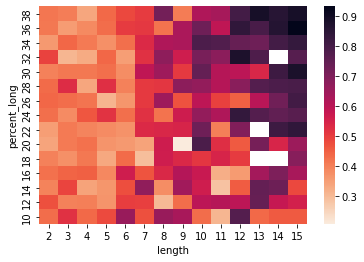

In [15]:
df_pivoted = df_total.pivot("percent_long", "length", "in_aster_frac")

fig, axes = plt.subplots()
ax = sns.heatmap(df_pivoted, cmap=sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

## Alternative method of identifying asters

In [21]:
def find_circle(x, xc, yc, r):
    y_upper = yc + np.sqrt(r**2 - (x - xc)**2)
    y_lower = yc - np.sqrt(r**2 - (x - xc)**2)
    return y_upper, y_lower


def in_circle(row, xc_2, yc_2, R_2):
    x_coord = row['posX']
    if x_coord < (xc_2 - R_2) or x_coord > (xc_2 + R_2):
        return 0
    else:
        upper_bound, lower_bound = find_circle(x_coord, xc_2, yc_2, R_2)
        y_coord = row['posY']
        if y_coord > upper_bound or y_coord < lower_bound:
            return 0
        else:
            return 1

def aster_fraction(row):
    series_index = int(row['series'])
    run_index = int(row['run'])
    print(series_index, run_index)
    if run_index < 10:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run000{}/fiber_position.txt'.format(series_index, run_index)
    elif run_index < 100:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run00{}/fiber_position.txt'.format(series_index, run_index)
    else:
        fpath = '~/thomsonlab/simulation/percolation/full-param-search{}/run0{}/fiber_position.txt'.format(series_index, run_index)

    df = pd.read_table(fpath,
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
    df = df.dropna(how='any')

    x = df['posX']
    y = df['posY']
    data = np.vstack((x, y))

    kde = stats.kde.gaussian_kde(data)
    gx, gy = np.mgrid[x.min():x.max():128j, y.min():y.max():128j]
    gxy = np.dstack((gx, gy)) # shape is (128, 128, 2)
    z = np.apply_along_axis(kde, 2, gxy)
    z = z.reshape(128, 128)

    center_ix, center_iy = np.unravel_index(z.argmax(), z.shape)
    center_x = center_ix / 128 * (x.max() - x.min()) + x.min()
    center_y = center_iy / 128 * (y.max() - y.min()) + y.min()

    df_short = df[df.length == 1]
    col = df_short.apply(in_circle, args=(center_x, center_y, 1), axis=1)
    df_short = df_short.assign(in_circle=col.values)

    return sum(df_short['in_circle']) / len(df_short)

In [22]:
col = df_total.apply(aster_fraction, axis=1)

2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 64
2 65
2 66
2 67
2 68
2 69
2 70
2 71
2 72
2 73
2 74
2 75
2 76
2 77
2 78
2 79
2 80
2 81
2 82
2 83
2 84
2 85
2 86
2 87
2 88
2 89
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
2 99
2 100
2 101
2 102
2 103
2 104
2 105
2 106
2 107
2 108
2 109
2 110
2 111
2 112
2 113
2 114
2 115
2 116
2 117
2 118
2 119
2 120
2 121
2 122
2 123
2 124
2 125
2 126
2 127
2 128
2 129
2 130
2 131
2 132
2 133
2 134
2 135
2 136
2 137
2 138
2 139
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
3 51
3 52
3 53
3 54
3 55


In [23]:
df_total = df_total.assign(in_aster_frac=col.values)
df_total = df_total.groupby(['length', 'percent_long']).mean().reset_index()

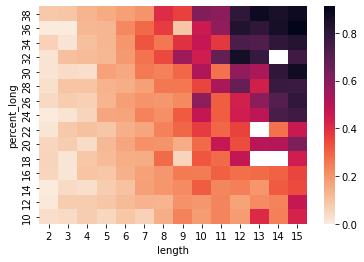

In [24]:
df_pivoted = df_total.pivot("percent_long", "length", "in_aster_frac")

fig, axes = plt.subplots()
ax = sns.heatmap(df_pivoted, cmap=sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()